# Stock price prediction

Stock price forecasting is an important part of the financial market analysis and can be applied in many ways. For example, algorithmic trading is one of the possible fields where the stock price prediction is especially relevant. This notebook contains different approaches to stock price forecasting, including both econometric and machine learning methods.

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras
from tensorflow.keras.layers import BatchNormalization, Dropout
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

To begin with, we download Apple stock prices for the period from January, 2015, to April, 2024, using Yahoo Finance API:

In [17]:
data = yf.download("AAPL", start="2015-01-01", end="2024-04-01")
print(data.head())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.435272  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.746893  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.749125  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.082138  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  25.007433  237458000


Yahoo finance API provides access to closing price and adjusted closing prices. The latter one is corrected for the dividends, splits, and new stock offerings to reflect in the share price. The code below is customisable, i.e. either the closing price ("Close") or the adjusted closing price ("Adj Close") can be chosen as a regressant in the further analysis.


The dataset is divided into 3 sections: train, test, and validation. Validation set is used to evaluate the performance of the trained model. These results are used to assess whether the models suffers from the overfitting or not. After all the nessary modifications of the models, the test set is applied to evaluate the performace of the model after training and tuning.
Observation belonging to 2024 constitute the test set, while the rest of the data is divided into 2 parts with the ratio 2:1.

In this analysis, adjusted close price is chosen as a dependent variable for simplification as additional corrections to the price data should not be made.

In [18]:
regressant = "Adj Close"
validation_share = 0.33
test_y = data.loc[data.index.year == 2024,regressant]
train_y, validation_y = train_test_split(data.loc[data.index.year < 2024,regressant], test_size=validation_share, random_state=7, shuffle=False)#shuffle=False because the data is time series

## Descriptive statistics

Firstly, let's analyse patterns and structural shifts present in the data. This is essential for understanding of the process we are going to model further as it influences the model choice in econometrics

<AxesSubplot:xlabel='Date'>

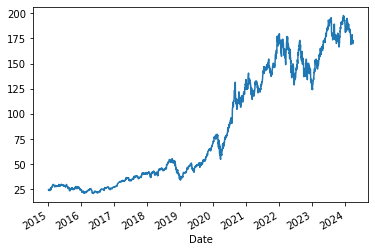

In [19]:
data[regressant].plot()

The plot above shows the closing price of the Apple stocks for the period used in the analysis. There is an increasing trend in the price, which exaggerated after approx. March, 2020, when the COVID-19 pandemic outbroke. At that time, technological companies were growing due to the need for most companies to operate remotely, which, in turn, boosted the demand for technology allowing to do that (computers, software, etc.).

It is clear that the data features structural changes. Not only the price stocks increased significantly, but also the volatility of the prices went up after 2020.

In [20]:
data[regressant].describe()

count    2325.000000
mean       84.673573
std        57.948009
min        20.772158
25%        33.559044
50%        53.052460
75%       143.335434
max       197.857529
Name: Adj Close, dtype: float64

### Neural networks 

LSTM are a type of neural networks which is frequently used to predict the stock prices. This model can capture the nonlinearity in the data, so it is allowed to use the raw data in the analysis, in comparison to econometric modelling where most methods require stationarity of the methods. 

The following model features can be modified when searching for the optimal model specification:
- number of layers
- learning rate
- number of lags

In this analysis, additional exogenous variables are not used. The model is purely based on the lags of the stock price for simplicity.

In [21]:
def get_lags_for_LSTM(data, lags):
    OUT = pd.DataFrame(index=data.index[lags:], columns=["y_t-"+str(i) for i in range(1,lags+1)])
    for i in range(0, len(OUT)):
        OUT.iloc[i,:]= data[i:i+lags].values
    return OUT
    

In [22]:
learning_rate=0.001
metric = 'mean_absolute_error'
save_best = True
n_epochs = 500
lags = 3

model = Sequential([
            layers.Input((lags, 1)),
            layers.LSTM(64, 'softmax', return_sequences=True),
            BatchNormalization(),
            layers.Dense(32, activation='softmax'),
            BatchNormalization(),
            layers.Dense(16, activation='relu'),
            BatchNormalization(),
            layers.Dense(4, activation='relu'),
            BatchNormalization(),
            layers.Dense(1)
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=learning_rate),
              metrics=[metric])
X_train = get_lags_for_LSTM(train_y, lags)
X_validation = get_lags_for_LSTM(validation_y, lags)
#model = LSTM_model(lags, learning_rate, metric)
if save_best:
    checkpoint_filepath = 'LSTM/model.keras'
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_'+metric,
    mode='min',
    save_best_only=True)
model_fit = model.fit(X_train.astype(np.float32), train_y[lags:].astype(np.float32), validation_data=(X_validation.astype(np.float32), validation_y[lags:].astype(np.float32)), epochs=n_epochs,callbacks=[model_checkpoint_callback])


Epoch 1/500
48/48 [==============================] - 4s 14ms/step - loss: 2664.1909 - mean_absolute_error: 46.1076 - val_loss: 24397.1348 - val_mean_absolute_error: 154.8908
Epoch 2/500
48/48 [==============================] - 0s 5ms/step - loss: 2617.7927 - mean_absolute_error: 45.9056 - val_loss: 24462.5859 - val_mean_absolute_error: 155.1019
Epoch 3/500
48/48 [==============================] - 0s 5ms/step - loss: 2579.6345 - mean_absolute_error: 45.6826 - val_loss: 24494.2148 - val_mean_absolute_error: 155.2038
Epoch 4/500
48/48 [==============================] - 0s 5ms/step - loss: 2536.8872 - mean_absolute_error: 45.4297 - val_loss: 24506.8730 - val_mean_absolute_error: 155.2447
Epoch 5/500
48/48 [==============================] - 0s 4ms/step - loss: 2490.6096 - mean_absolute_error: 45.1462 - val_loss: 24597.7422 - val_mean_absolute_error: 155.5371
Epoch 6/500
48/48 [==============================] - 0s 4ms/step - loss: 2444.6030 - mean_absolute_error: 44.8344 - val_loss: 24678.78

In [23]:
# Get MAE for train and validation sets
train_mae = model_fit.history[metric]
val_mae = model_fit.history['val_'+metric]

# Get the minimum validation MAE and its corresponding epoch
best_val_mae = min(val_mae)
best_val_epoch = val_mae.index(best_val_mae) + 1  # Add 1 because epoch indexing starts from 1

print("Best validation MAE:", best_val_mae)
print("Epoch of the best validation MAE:", best_val_epoch)

# Load the best model
best_model = tensorflow.keras.models.load_model(checkpoint_filepath)

# Evaluate the best model on train and validation sets
train_mae_best_model = best_model.evaluate(X_train.astype(np.float32), train_y[lags:].astype(np.float32), verbose=0)[1]
val_mae_best_model = best_model.evaluate(X_validation.astype(np.float32), validation_y[lags:].astype(np.float32), verbose=0)[1]

print("MAE of the best model on train set:", train_mae_best_model)
print("MAE of the best model on validation set:", val_mae_best_model)

Best validation MAE: 5.969880104064941
Epoch of the best validation MAE: 449
MAE of the best model on train set: 5.863924980163574
MAE of the best model on validation set: 5.969880104064941


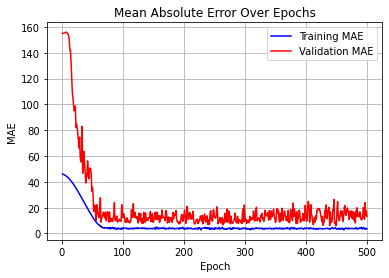

In [24]:
mae = model_fit.history['mean_absolute_error']
val_mae = model_fit.history['val_mean_absolute_error']

# Plot MAE
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
model_final = tensorflow.keras.models.load_model(checkpoint_filepath)

In [26]:
preds_test = model_final.predict(test_y)
preds_train = model_final.predict(train_y)
preds_val = model_final.predict(validation_y)

24/24 [==============================] - 0s 1ms/step


In [27]:
preds_test = preds_test.reshape(len(preds_test))
preds_train = preds_train.reshape(len(preds_train))
preds_val = preds_val.reshape(len(preds_val))

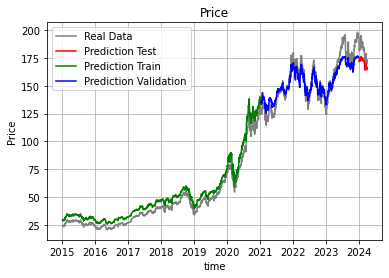

In [28]:
# Plot MAE
plt.plot(data[regressant].index, data[regressant], 'gray', label='Real Data')
plt.plot(test_y.index, preds_test, 'r', label='Prediction Test')
plt.plot(train_y.index, preds_train, 'g', label='Prediction Train')
plt.plot(validation_y.index, preds_val, 'b', label='Prediction Validation')
plt.title('Price')
plt.xlabel('time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
# Initialize figure
fig = go.Figure()

# Color palette
colors = px.colors.qualitative.G10

# Add traces for real data and predictions using the defined colors
fig.add_trace(go.Scatter(x=data[regressant].index, y=data[regressant], mode='lines', line=dict(color='gray', width=2), name='Real Data'))
fig.add_trace(go.Scatter(x=test_y.index, y=preds_test, mode='lines', line=dict(color=colors[1], width=2), name='Prediction Test'))
fig.add_trace(go.Scatter(x=train_y.index, y=preds_train, mode='lines', line=dict(color=colors[3], width=2), name='Prediction Train'))
fig.add_trace(go.Scatter(x=validation_y.index, y=preds_val, mode='lines', line=dict(color=colors[0], width=2), name='Prediction Validation'))

# Update layout
fig.update_layout(
    title='Price Prediction, AAPL',
    xaxis_title='Time',
    yaxis_title='Price',
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray'),
    width=1000,  # Adjust the width as necessary
    height=600  # Maintain aspect ratio or adjust the height accordingly
)

# Show the plot
fig.show()


The model overestimates values in the training set. It is more precise on the validation data, while underestimating the stock prices on the test set. Therefore, it would make sense to continue to modify the model in order to achieve better accuracy and reduce the bias.